### Этап анализа данных

#### Датасет 
https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data

#### Описание
Набор характеристик клиентов страховой компании (автострахование) и страховых программ.

#### Данные

* Response: флаг принятия нового оффера - **целевая переменная**
* Coverage: тип полиса (базовый, расширенный, премиум)
* Monthly Premium Auto: стоимость страховки (ежемесячно)
* Months Since Last Claim: месяцев с момента последнего страхового случая
* Months Since Policy Inception: месяцев действует страховка
* Number of Open Complaints: количество нерешенных обращений клиента
* Number of Policies: количество страховок 
* Policy Type: тип страховки (корпоративное авто, личное, специальное)
* Policy: 3 варианта (L1, L2, L3) для каждого типа (Corporate, Personal, Special)
* Renew Offer Type: 4 типа офферов по продлению (Offer 1, Offer 2, Offer 3, Offer 4)
* Sales Channel: канал взаимодействия (представитель, офис, колл центр, онлайн)
* Total Claim Amount: сумма страховых случаев
* Effective To Date: срок истечения страховки - для того, чтобы учитывать в модели, вероятно, стоит перевести в количество дней
* Customer: идентификатор клиента - **исключаем как незначащий параметр**
* Customer Lifetime Value: "прибыльность" клиента за весь период пользования страховой
* State: штат
* Education: образование (High School or less, College, BA, MA , PHD)
* Employment Status: трудоустройство (работающий, безработный, пенсионер, недееспособный, больничный)
* Gender: пол
* Income: годовой доход
* Location Code: тип населенного пункта (сельский, пригород, город)
* Marital Status: замужество (Single, Married, Divorced)
* Vehicle Class: тип машины (4-Door, Luxury, Luxury SUV, Sports Car, SUV, 2-Door)
* Vehicle Size: размер машины (Large, Midsize, Small)

In [1]:
import pandas as pd
df = pd.read_csv(f"D:\datasets\customer_value_data\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv", low_memory=False)

Выберем фичи, которые могут оказывать влияние

In [2]:
interesting_features = ['Customer Lifetime Value','Income','Monthly Premium Auto',\
                                'Months Since Last Claim','Months Since Policy Inception', \
                                'Number of Open Complaints','Number of Policies','Total Claim Amount', \
                                'Effective To Date', 'Coverage','Policy','Education','Location Code','Vehicle Size', \
                                'Policy Type','Renew Offer Type','Sales Channel','State','EmploymentStatus', \
                                'Gender','Marital Status','Vehicle Class', 'Response']
df = df[interesting_features]

Преобразуем целевую переменную в числовой показатель (1, 0)

In [3]:
def target_score(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        raise ValueError("Bad target value")
    
df['Response'] = df['Response'].apply(target_score)

От даты в явном виде тоже мало смысла, переведем даты в количество дней

In [4]:
from datetime import datetime

def transform_date(x):
    dt1 = datetime.strptime("2011-01-01", "%Y-%m-%d")
    dt2 = datetime.strptime(x, "%m/%d/%y")
    return (dt2-dt1).days        

df['Effective To Date'] = df['Effective To Date'].apply(transform_date)

Распределим фичи по категориям (числовые, категориальные, целевая переменная)

In [5]:
numerical_features = ['Customer Lifetime Value','Income','Monthly Premium Auto',\
                            'Months Since Last Claim','Months Since Policy Inception', \
                            'Number of Open Complaints','Number of Policies','Total Claim Amount', \
                            'Effective To Date'] 

target_feature = ['Response']

categorical_features = [
    col for col in df.columns if col not in numerical_features + target_feature
]

all_features = categorical_features + numerical_features

Посмотрим на данные и их распределение

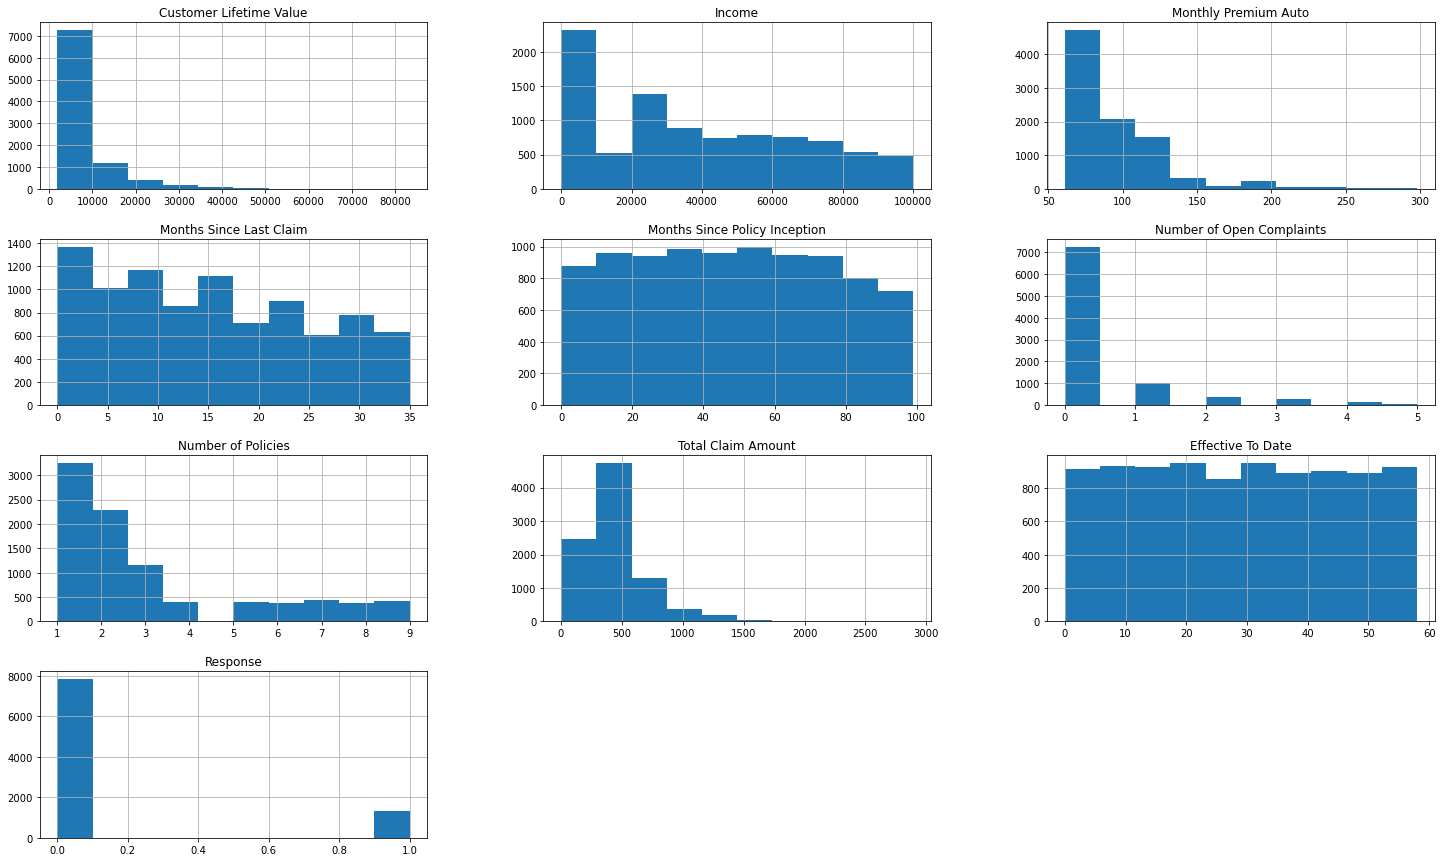

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

df.hist(figsize=(25, 15))

plt.show()

Посмотрим на зависимости между фичами

<AxesSubplot:>

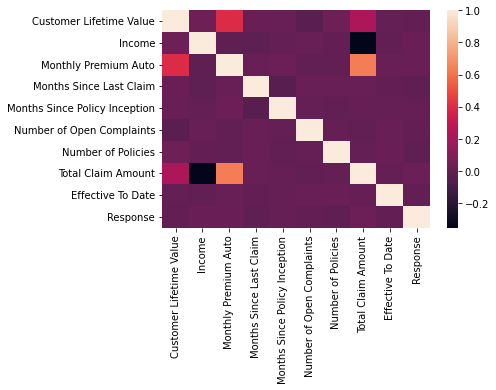

In [7]:
import seaborn as sns

sns.heatmap(df.corr())

Соберем простой пайп

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn
sklearn.set_config(display='diagram')


numerical_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features),
])

preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])


from sklearn.ensemble import GradientBoostingClassifier
classifier_sklearn_pipline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", GradientBoostingClassifier(n_estimators=200, max_depth=3))
    ])


import xgboost
classifier_xgboot_pipline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", xgboost.XGBClassifier())
    ])


from catboost import CatBoostClassifier
classifier_catboost_pipline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", CatBoostClassifier())
    ])


import lightgbm
classifier_lgbm_pipline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", lightgbm.LGBMClassifier())
    ])

In [9]:
classifier_sklearn_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Customer '
                                                                    'Lifetime '
                                                                    'Value',
                                                                    'Income',
                                                                    'Monthly '
                                                                    'Premium '
                                                                    'Auto',
                                                                    'Months '
                                                                    'Since '
                                                                    'Last '
                                                                    'Claim',
                                                                    'Months '
                                                                    'Since '
                                                                    'Policy '
                                                                    'Inception',
                                                                    'Number of '
                                                                    'Open '
                                                                    'Complaints',
                                                                    'Number of '
                                                                    'Policies',
                                                                    'Total '
                                                                    'Claim '...
                                                                    'To Date']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Coverage',
                                                                    'Policy',
                                                                    'Education',
                                                                    'Location '
                                                                    'Code',
                                                                    'Vehicle '
                                                                    'Size',
                                                                    'Policy '
                                                                    'Type',
                                                                    'Renew '
                                                                    'Offer '
                                                                    'Type',
                                                                    'Sales '
                                                                    'Channel',
                                                                    'State',
                                                                    'EmploymentStatus',
                                                                    'Gender',
                                                                    'Marital '
                                                                    'Status',
                                

In [10]:
classifier_xgboot_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Customer '
                                                                    'Lifetime '
                                                                    'Value',
                                                                    'Income',
                                                                    'Monthly '
                                                                    'Premium '
                                                                    'Auto',
                                                                    'Months '
                                                                    'Since '
                                                                    'Last '
                                                                    'Claim',
                                                                    'Months '
                                                                    'Since '
                                                                    'Policy '
                                                                    'Inception',
                                                                    'Number of '
                                                                    'Open '
                                                                    'Complaints',
                                                                    'Number of '
                                                                    'Policies',
                                                                    'Total '
                                                                    'Claim '...
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=None))])

In [11]:
classifier_catboost_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Customer '
                                                                    'Lifetime '
                                                                    'Value',
                                                                    'Income',
                                                                    'Monthly '
                                                                    'Premium '
                                                                    'Auto',
                                                                    'Months '
                                                                    'Since '
                                                                    'Last '
                                                                    'Claim',
                                                                    'Months '
                                                                    'Since '
                                                                    'Policy '
                                                                    'Inception',
                                                                    'Number of '
                                                                    'Open '
                                                                    'Complaints',
                                                                    'Number of '
                                                                    'Policies',
                                                                    'Total '
                                                                    'Claim '...
                                                                  ('categorical',
                                                                   Pipeline(steps=[('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Coverage',
                                                                    'Policy',
                                                                    'Education',
                                                                    'Location '
                                                                    'Code',
                                                                    'Vehicle '
                                                                    'Size',
                                                                    'Policy '
                                                                    'Type',
                                                                    'Renew '
                                                                    'Offer '
                                                                    'Type',
                                                                    'Sales '
                                                                    'Channel',
                                                                    'State',
                                                                    'EmploymentStatus',
                                                                    'Gender',
                                                                    'Marital '
                                                                    'Status',
                                                                    'Vehicle '
                                  

In [12]:
classifier_lgbm_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Customer '
                                                                    'Lifetime '
                                                                    'Value',
                                                                    'Income',
                                                                    'Monthly '
                                                                    'Premium '
                                                                    'Auto',
                                                                    'Months '
                                                                    'Since '
                                                                    'Last '
                                                                    'Claim',
                                                                    'Months '
                                                                    'Since '
                                                                    'Policy '
                                                                    'Inception',
                                                                    'Number of '
                                                                    'Open '
                                                                    'Complaints',
                                                                    'Number of '
                                                                    'Policies',
                                                                    'Total '
                                                                    'Claim '
                                                                    'Amount',
                                                                    'Effective '
                                                                    'To Date']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Coverage',
                                                                    'Policy',
                                                                    'Education',
                                                                    'Location '
                                                                    'Code',
                                                                    'Vehicle '
                                                                    'Size',
                                                                    'Policy '
                                                                    'Type',
                                                                    'Renew '
                                                                    'Offer '
                                                                    'Type',
                                                                    'Sales '
                                                                    'Channel',
                                                                    'State',
                                                                    'EmploymentStatus',
                                                                    'Gender',
                                 

Разобьем на тест и трейн с учетом распределения по целевой переменной. Намеренно оставляем трейн выборку не большой, а то получаются слишком хорошие результаты

In [13]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(df[all_features + target_feature], test_size=0.6, \
                                         stratify=df[target_feature])
print(data_train.shape, data_test.shape)

(3653, 23) (5481, 23)


Обучаем все наши варианты бустинга

In [14]:
classifier_sklearn_pipline.fit(data_train[all_features], data_train[target_feature[0]])
classifier_xgboot_pipline.fit(data_train[all_features], data_train[target_feature[0]])
classifier_catboost_pipline.fit(data_train[all_features], data_train[target_feature[0]])
classifier_lgbm_pipline.fit(data_train[all_features], data_train[target_feature[0]])

D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:38:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.017914
0:	learn: 0.6779031	total: 126ms	remaining: 2m 6s
1:	learn: 0.6650805	total: 130ms	remaining: 1m 5s
2:	learn: 0.6531281	total: 133ms	remaining: 44.1s
3:	learn: 0.6409889	total: 137ms	remaining: 34.1s
4:	learn: 0.6293245	total: 141ms	remaining: 28.1s
5:	learn: 0.6181603	total: 146ms	remaining: 24.2s
6:	learn: 0.6054954	total: 150ms	remaining: 21.3s
7:	learn: 0.5957904	total: 154ms	remaining: 19.1s
8:	learn: 0.5841690	total: 158ms	remaining: 17.4s
9:	learn: 0.5738258	total: 163ms	remaining: 16.1s
10:	learn: 0.5645573	total: 167ms	remaining: 15.1s
11:	learn: 0.5549294	total: 173ms	remaining: 14.2s
12:	learn: 0.5459646	total: 177ms	remaining: 13.5s
13:	lea

156:	learn: 0.2631001	total: 1.06s	remaining: 5.67s
157:	learn: 0.2625713	total: 1.06s	remaining: 5.68s
158:	learn: 0.2621136	total: 1.07s	remaining: 5.67s
159:	learn: 0.2615526	total: 1.08s	remaining: 5.66s
160:	learn: 0.2609818	total: 1.08s	remaining: 5.65s
161:	learn: 0.2607920	total: 1.09s	remaining: 5.66s
162:	learn: 0.2600928	total: 1.1s	remaining: 5.67s
163:	learn: 0.2596935	total: 1.11s	remaining: 5.66s
164:	learn: 0.2592042	total: 1.12s	remaining: 5.66s
165:	learn: 0.2587013	total: 1.13s	remaining: 5.66s
166:	learn: 0.2583814	total: 1.13s	remaining: 5.65s
167:	learn: 0.2579289	total: 1.14s	remaining: 5.65s
168:	learn: 0.2573864	total: 1.15s	remaining: 5.64s
169:	learn: 0.2569610	total: 1.15s	remaining: 5.64s
170:	learn: 0.2567567	total: 1.16s	remaining: 5.64s
171:	learn: 0.2563056	total: 1.17s	remaining: 5.64s
172:	learn: 0.2555327	total: 1.18s	remaining: 5.64s
173:	learn: 0.2550928	total: 1.19s	remaining: 5.64s
174:	learn: 0.2545025	total: 1.2s	remaining: 5.65s
175:	learn: 0.

338:	learn: 0.1897943	total: 2.53s	remaining: 4.94s
339:	learn: 0.1895894	total: 2.54s	remaining: 4.93s
340:	learn: 0.1893983	total: 2.55s	remaining: 4.92s
341:	learn: 0.1891914	total: 2.55s	remaining: 4.92s
342:	learn: 0.1889514	total: 2.56s	remaining: 4.9s
343:	learn: 0.1886306	total: 2.56s	remaining: 4.89s
344:	learn: 0.1883828	total: 2.57s	remaining: 4.88s
345:	learn: 0.1879847	total: 2.57s	remaining: 4.87s
346:	learn: 0.1878250	total: 2.58s	remaining: 4.85s
347:	learn: 0.1875961	total: 2.58s	remaining: 4.84s
348:	learn: 0.1874078	total: 2.59s	remaining: 4.83s
349:	learn: 0.1872236	total: 2.59s	remaining: 4.82s
350:	learn: 0.1869719	total: 2.6s	remaining: 4.8s
351:	learn: 0.1866663	total: 2.6s	remaining: 4.79s
352:	learn: 0.1863902	total: 2.61s	remaining: 4.78s
353:	learn: 0.1861646	total: 2.61s	remaining: 4.76s
354:	learn: 0.1859970	total: 2.62s	remaining: 4.75s
355:	learn: 0.1857783	total: 2.62s	remaining: 4.74s
356:	learn: 0.1853182	total: 2.63s	remaining: 4.75s
357:	learn: 0.18

514:	learn: 0.1437355	total: 3.76s	remaining: 3.54s
515:	learn: 0.1434774	total: 3.76s	remaining: 3.53s
516:	learn: 0.1432783	total: 3.77s	remaining: 3.52s
517:	learn: 0.1430875	total: 3.77s	remaining: 3.51s
518:	learn: 0.1428576	total: 3.78s	remaining: 3.5s
519:	learn: 0.1425854	total: 3.79s	remaining: 3.5s
520:	learn: 0.1424380	total: 3.79s	remaining: 3.49s
521:	learn: 0.1422212	total: 3.82s	remaining: 3.5s
522:	learn: 0.1420796	total: 3.83s	remaining: 3.49s
523:	learn: 0.1418789	total: 3.83s	remaining: 3.48s
524:	learn: 0.1417551	total: 3.84s	remaining: 3.47s
525:	learn: 0.1416225	total: 3.85s	remaining: 3.47s
526:	learn: 0.1413594	total: 3.85s	remaining: 3.46s
527:	learn: 0.1410529	total: 3.86s	remaining: 3.45s
528:	learn: 0.1407156	total: 3.87s	remaining: 3.44s
529:	learn: 0.1404015	total: 3.87s	remaining: 3.43s
530:	learn: 0.1401915	total: 3.88s	remaining: 3.42s
531:	learn: 0.1400381	total: 3.88s	remaining: 3.42s
532:	learn: 0.1398599	total: 3.89s	remaining: 3.41s
533:	learn: 0.1

676:	learn: 0.1122900	total: 5.05s	remaining: 2.41s
677:	learn: 0.1121189	total: 5.07s	remaining: 2.41s
678:	learn: 0.1119962	total: 5.08s	remaining: 2.4s
679:	learn: 0.1118744	total: 5.1s	remaining: 2.4s
680:	learn: 0.1117265	total: 5.11s	remaining: 2.39s
681:	learn: 0.1116162	total: 5.13s	remaining: 2.39s
682:	learn: 0.1113871	total: 5.14s	remaining: 2.38s
683:	learn: 0.1111770	total: 5.15s	remaining: 2.38s
684:	learn: 0.1110685	total: 5.16s	remaining: 2.37s
685:	learn: 0.1109329	total: 5.16s	remaining: 2.36s
686:	learn: 0.1108116	total: 5.17s	remaining: 2.36s
687:	learn: 0.1106078	total: 5.18s	remaining: 2.35s
688:	learn: 0.1103891	total: 5.19s	remaining: 2.34s
689:	learn: 0.1102748	total: 5.2s	remaining: 2.33s
690:	learn: 0.1101074	total: 5.21s	remaining: 2.33s
691:	learn: 0.1099117	total: 5.22s	remaining: 2.32s
692:	learn: 0.1096499	total: 5.22s	remaining: 2.31s
693:	learn: 0.1094573	total: 5.26s	remaining: 2.32s
694:	learn: 0.1093867	total: 5.28s	remaining: 2.32s
695:	learn: 0.10

857:	learn: 0.0867398	total: 6.71s	remaining: 1.11s
858:	learn: 0.0866024	total: 6.72s	remaining: 1.1s
859:	learn: 0.0865583	total: 6.72s	remaining: 1.09s
860:	learn: 0.0864243	total: 6.73s	remaining: 1.09s
861:	learn: 0.0863235	total: 6.74s	remaining: 1.08s
862:	learn: 0.0862139	total: 6.74s	remaining: 1.07s
863:	learn: 0.0860925	total: 6.75s	remaining: 1.06s
864:	learn: 0.0860074	total: 6.76s	remaining: 1.05s
865:	learn: 0.0859446	total: 6.77s	remaining: 1.05s
866:	learn: 0.0858403	total: 6.79s	remaining: 1.04s
867:	learn: 0.0857255	total: 6.8s	remaining: 1.03s
868:	learn: 0.0856104	total: 6.8s	remaining: 1.02s
869:	learn: 0.0854996	total: 6.81s	remaining: 1.02s
870:	learn: 0.0854025	total: 6.82s	remaining: 1.01s
871:	learn: 0.0852778	total: 6.83s	remaining: 1s
872:	learn: 0.0851939	total: 6.84s	remaining: 995ms
873:	learn: 0.0850615	total: 6.84s	remaining: 987ms
874:	learn: 0.0850114	total: 6.85s	remaining: 979ms
875:	learn: 0.0849337	total: 6.88s	remaining: 974ms
876:	learn: 0.0848

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Customer '
                                                                    'Lifetime '
                                                                    'Value',
                                                                    'Income',
                                                                    'Monthly '
                                                                    'Premium '
                                                                    'Auto',
                                                                    'Months '
                                                                    'Since '
                                                                    'Last '
                                                                    'Claim',
                                                                    'Months '
                                                                    'Since '
                                                                    'Policy '
                                                                    'Inception',
                                                                    'Number of '
                                                                    'Open '
                                                                    'Complaints',
                                                                    'Number of '
                                                                    'Policies',
                                                                    'Total '
                                                                    'Claim '
                                                                    'Amount',
                                                                    'Effective '
                                                                    'To Date']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Coverage',
                                                                    'Policy',
                                                                    'Education',
                                                                    'Location '
                                                                    'Code',
                                                                    'Vehicle '
                                                                    'Size',
                                                                    'Policy '
                                                                    'Type',
                                                                    'Renew '
                                                                    'Offer '
                                                                    'Type',
                                                                    'Sales '
                                                                    'Channel',
                                                                    'State',
                                                                    'EmploymentStatus',
                                                                    'Gender',
                                 

Посмотрим чему научилась модель

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer

print("SKLearn")
print(classification_report(data_test[target_feature[0]], 
                            classifier_sklearn_pipline.predict(data_test[all_features])))

SKLearn
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4696
           1       0.90      0.45      0.60       785

    accuracy                           0.91      5481
   macro avg       0.91      0.72      0.78      5481
weighted avg       0.91      0.91      0.90      5481



In [16]:
print("XGBoost")
print(classification_report(data_test[target_feature[0]], 
                            classifier_xgboot_pipline.predict(data_test[all_features])))

XGBoost
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.93      0.94      0.94       785

    accuracy                           0.98      5481
   macro avg       0.96      0.96      0.96      5481
weighted avg       0.98      0.98      0.98      5481



In [17]:
print("CatBoost")
print(classification_report(data_test[target_feature[0]], 
                            classifier_catboost_pipline.predict(data_test[all_features])))

CatBoost
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4696
           1       0.96      0.72      0.83       785

    accuracy                           0.96      5481
   macro avg       0.96      0.86      0.90      5481
weighted avg       0.96      0.96      0.95      5481



In [18]:
print("LGBM")
print(classification_report(data_test[target_feature[0]], 
                            classifier_lgbm_pipline.predict(data_test[all_features])))

LGBM
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4696
           1       0.95      0.88      0.91       785

    accuracy                           0.98      5481
   macro avg       0.97      0.94      0.95      5481
weighted avg       0.98      0.98      0.98      5481



Если оценивать модели по показателю accurancy, то лучшие результаты при конфигурации гиперпараметров по умолчанию показал XGBoost (0,98)

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score, average="macro")


In [20]:
param_grid = {
    'classifier__n_estimators':[1, 50, 100],
    'classifier__max_depth':[1, 3, 7]
}

search = GridSearchCV(classifier_sklearn_pipline, param_grid, 
                      verbose=True, 
                      n_jobs=-1, cv=3, scoring=f1)

search.fit(data_train.drop(target_feature, axis=1), data_train[target_feature[0]])
print(f"SKLearn best estimator. Best hyper-params: {search.best_params_}")
print(classification_report(data_test[target_feature[0]], 
                            search.best_estimator_.predict(data_test[all_features])))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
SKLearn best estimator. Best hyper-params: {'classifier__max_depth': 7, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4696
           1       0.95      0.89      0.92       785

    accuracy                           0.98      5481
   macro avg       0.97      0.94      0.95      5481
weighted avg       0.98      0.98      0.98      5481



In [21]:
param_grid = {
    'classifier__eta':[0.3, 0.5, 1],
    'classifier__max_depth':[1, 3, 7],
    'classifier__objective':['binary:logistic', 'binary:logitraw'],
}

search = GridSearchCV(classifier_xgboot_pipline, param_grid, 
                      verbose=True, 
                      n_jobs=-1, cv=3, scoring=f1)

search.fit(data_train.drop(target_feature, axis=1), data_train[target_feature[0]])
print(f"XGBoost best estimator. Best hyper-params: {search.best_params_}")
print(classification_report(data_test[target_feature[0]], 
                            search.best_estimator_.predict(data_test[all_features])))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:39:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost best estimator. Best hyper-params: {'classifier__eta': 0.3, 'classifier__max_depth': 7, 'classifier__objective': 'binary:logitraw'}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.95      0.94      0.94       785

    accuracy                           0.98      5481
   macro avg       0.97      0.97      0.97      5481
weighted avg       0.98      0.98      0.98      5481



In [22]:
param_grid = {
    'classifier__n_estimators':[50, 100],
    'classifier__max_depth':[1, 3, 7],
    'classifier__num_leaves':[2, 5, 10],
}

search = GridSearchCV(classifier_catboost_pipline, param_grid, 
                      verbose=True, 
                      n_jobs=-1, cv=3, scoring=f1)

search.fit(data_train.drop(target_feature, axis=1), data_train[target_feature[0]])
print(f"CatBoost best estimator. Best hyper-params: {search.best_params_}")
print(classification_report(data_test[target_feature[0]], 
                            search.best_estimator_.predict(data_test[all_features])))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


D:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.61361427        nan        nan 0.61421622        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


Learning rate set to 0.147974
0:	learn: 0.5945880	total: 3.7ms	remaining: 366ms
1:	learn: 0.5270094	total: 7.61ms	remaining: 373ms
2:	learn: 0.4808076	total: 11.4ms	remaining: 370ms
3:	learn: 0.4475238	total: 14.7ms	remaining: 354ms
4:	learn: 0.4245244	total: 18.5ms	remaining: 351ms
5:	learn: 0.4100400	total: 23.1ms	remaining: 362ms
6:	learn: 0.3971270	total: 26.8ms	remaining: 356ms
7:	learn: 0.3850938	total: 30.6ms	remaining: 352ms
8:	learn: 0.3783455	total: 34.3ms	remaining: 347ms
9:	learn: 0.3735696	total: 37.9ms	remaining: 341ms
10:	learn: 0.3694070	total: 42ms	remaining: 340ms
11:	learn: 0.3657114	total: 45.5ms	remaining: 333ms
12:	learn: 0.3632453	total: 49.1ms	remaining: 328ms
13:	learn: 0.3613698	total: 53.3ms	remaining: 327ms
14:	learn: 0.3591719	total: 56.9ms	remaining: 323ms
15:	learn: 0.3517714	total: 61.4ms	remaining: 322ms
16:	learn: 0.3508181	total: 65.1ms	remaining: 318ms
17:	learn: 0.3479623	total: 69.3ms	remaining: 316ms
18:	learn: 0.3470557	total: 72.6ms	remaining: 3

In [23]:
param_grid = {
    'classifier__boosting_type':['gbdt','dart'],
    'classifier__max_depth':[1, 3, 7],
    'classifier__n_estimators':[50, 100, 150],
}

search = GridSearchCV(classifier_lgbm_pipline, param_grid, 
                      verbose=True, 
                      n_jobs=-1, cv=3, scoring=f1)

search.fit(data_train.drop(target_feature, axis=1), data_train[target_feature[0]])
print(f"LGBM best estimator. Best hyper-params: {search.best_params_}")
print(classification_report(data_test[target_feature[0]], 
                            search.best_estimator_.predict(data_test[all_features])))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
LGBM best estimator. Best hyper-params: {'classifier__boosting_type': 'gbdt', 'classifier__max_depth': 7, 'classifier__n_estimators': 150}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.94      0.93      0.93       785

    accuracy                           0.98      5481
   macro avg       0.96      0.96      0.96      5481
weighted avg       0.98      0.98      0.98      5481



# Выводы
1. Использование пайпов очень упрощает работу с данными и структурирует процесс.
2. Не очевидно может ли пайп помочь в случае, когда требуется использовать несколько эстимейторов, но не блендить или стечить их, а просто все результаты для ручного анализа.
3. С гиперпараметрами по умолчанию лучше справился с задачей XGBoost.
4. При настройке гиперпараметром через gridsearchCV лучшим остался XGBoost. Скорее всего это связано с тем, что гиперпараметры выбирались мной рандомно за неимением опыта работы с данными классификаторами и примерным пониманием каких границах и какие гиперпараметры лучше использовать. Уделять этому слишком много времени не выглядит необходимым, так как цель задания скорее познакомиться с техниками и закрепить их на практике, нежели найти лучший классификатор и лучшие параметры.